# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [2]:
import pandas as pd
import numpy as np
import math
import json

import itertools

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

import warnings
warnings.filterwarnings("ignore")

from tqdm._tqdm_notebook import tqdm_notebook
from tqdm import tqdm

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Portfolio

In [3]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


## Data Cleaning : Portfolio

In [4]:
# Rename portfolio id column to offer_id column to remove confusion between different id column in other dataframes
portfolio.rename(columns={'id':'offer_id'}, inplace=True)

In [5]:
portfolio

,reward,channels,difficulty,duration,offer_type,offer_id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [6]:
# One-Hot encoding of offer type column
df_temp=pd.get_dummies(data=portfolio.offer_type, prefix='offer_type')
df_portfolio=pd.concat([portfolio, df_temp], axis=1)
df_portfolio.drop('offer_type', axis=1, inplace=True)


In [7]:
# Converting Channels variable into respective columns
unq_channels=list(set(itertools.chain(*portfolio['channels'].tolist())))
for channel in unq_channels:
    df_portfolio[channel] = df_portfolio.channels.apply(lambda x:1 if channel in x else 0 )
df_portfolio.drop('channels', axis=1, inplace=True)   

In [8]:
df_portfolio

,reward,difficulty,duration,offer_id,offer_type_bogo,offer_type_discount,offer_type_informational,social,mobile,web,email
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,1,0,0,1,1,0,1
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,0,0,1,1,1,1
2,0,0,4,3f207df678b143eea3cee63160fa8bed,0,0,1,0,1,1,1
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,0,1,1,1
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,0,0,1,1
5,3,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,0,1,0,1,1,1,1
6,2,10,10,fafdcd668e3743c1bb461111dcafc2a4,0,1,0,1,1,1,1
7,0,0,3,5a8bc65990b245e5a138643cd4eb9837,0,0,1,1,1,0,1
8,5,5,5,f19421c1d4aa40978ebb69ca19b0e20d,1,0,0,1,1,1,1
9,2,10,7,2906b810c7d4411798c6938adc9daaa5,0,1,0,0,1,1,1


In [9]:
df_portfolio.sum()

reward                                                                     42
difficulty                                                                 77
duration                                                                   65
offer_id                    ae264e3637204a6fb9bb56bc8210ddfd4d5c57ea9a6940...
offer_type_bogo                                                             4
offer_type_discount                                                         4
offer_type_informational                                                    2
social                                                                      6
mobile                                                                      9
web                                                                         8
email                                                                      10
dtype: object

# Transcript

In [10]:
transcript

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714


## Data Cleaning : Transcript

In [11]:
#rename column id to customer_id for future merging purpose
transcript.rename(columns={'person':'customer_id'}, inplace=True)

In [12]:
#Change and rouding off the time in hours into days for better understanding 
transcript['days'] = transcript.time.apply(lambda x: round(x/24.0))
#transcript.rename(columns={'time':'days'}, inplace=True)
transcript


,customer_id,event,value,time,days
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,0
...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714,30
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714,30
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714,30
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714,30


In [13]:
transcript['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [14]:
transcript[transcript['event']=='transaction']

,customer_id,event,value,time,days
12654,02c083884c7d45b39cc68e1314fec56c,transaction,{'amount': 0.8300000000000001},0,0
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,{'amount': 34.56},0,0
12659,54890f68699049c2a04d415abc25e717,transaction,{'amount': 13.23},0,0
12670,b2f1cd155b864803ad8334cdf13c4bd2,transaction,{'amount': 19.51},0,0
12671,fe97aa22dd3e48c8b143116a8403dd52,transaction,{'amount': 18.97},0,0
...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714,30
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714,30
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714,30
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714,30


In [15]:
transcript[transcript['event']=='offer received']

,customer_id,event,value,time,days
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,0
...,...,...,...,...,...
257882,d087c473b4d247ccb0abfef59ba12b0e,offer received,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},576,24
257883,cb23b66c56f64b109d673d5e56574529,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},576,24
257884,6d5f3a774f3d4714ab0c092238f3a1d7,offer received,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},576,24
257885,9dc1421481194dcd9400aec7c9ae6366,offer received,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},576,24


In [16]:
transcript[transcript.event!='transaction']['value']

0          {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1          {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2          {'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3          {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4          {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
                                ...                        
306497    {'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2...
306506    {'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...
306507     {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
306509    {'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...
306527    {'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...
Name: value, Length: 167581, dtype: object

In [17]:
transcript.loc[306509]['value']

{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4', 'reward': 2}

In [18]:
transcript[transcript.event!='transaction']

,customer_id,event,value,time,days
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,0
...,...,...,...,...,...
306497,a6f84f4e976f44508c358cc9aba6d2b3,offer completed,{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2...,714,30
306506,b895c57e8cd047a8872ce02aa54759d6,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,714,30
306507,8dda575c2a1d44b9ac8e8b07b93d1f8e,offer viewed,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},714,30
306509,8431c16f8e1d440880db371a68f82dd0,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,714,30


In [19]:
#Transaction has amount variable under value, and offer received, offer viewed and offer completed has offer id
#Extract the variables from value column 
transcript['amount'] = transcript['value'].apply(lambda x: x.get('amount', np.nan))
transcript['offer_id'] = transcript['value'].apply(lambda x: x.get('offer id', x.get('offer_id',np.nan)))
transcript.drop('value',inplace=True, axis=1)

In [20]:
transcript

,customer_id,event,time,days,amount,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,0,0,NaN,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,0,NaN,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0
...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,714,30,1.59,NaN
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,30,9.53,NaN
306531,a00058cf10334a308c68e7631c529907,transaction,714,30,3.61,NaN
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,30,3.53,NaN


In [21]:
transcript_offer=transcript[transcript['amount'].isnull()]
transcript_offer.drop('amount', axis=1, inplace=True)
transcript_offer['event'].unique()



array(['offer received', 'offer viewed', 'offer completed'], dtype=object)

In [22]:
transcript_offer.reset_index(inplace=True, drop=True)
transcript_offer

,customer_id,event,time,days,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,0,0,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,0,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0
...,...,...,...,...,...
167576,a6f84f4e976f44508c358cc9aba6d2b3,offer completed,714,30,2298d6c36e964ae4a3e7e9706d1fb8c2
167577,b895c57e8cd047a8872ce02aa54759d6,offer completed,714,30,fafdcd668e3743c1bb461111dcafc2a4
167578,8dda575c2a1d44b9ac8e8b07b93d1f8e,offer viewed,714,30,0b1e1539f2cc45b7b9fa7c272da2e1d7
167579,8431c16f8e1d440880db371a68f82dd0,offer completed,714,30,fafdcd668e3743c1bb461111dcafc2a4


In [23]:
df_temp=pd.get_dummies(data=transcript_offer.event )
df_transcript_offer=pd.concat([transcript_offer,df_temp], axis=1)
df_transcript_offer.rename({'offer completed':'completed','offer received':'received', 'offer viewed': 'viewed'},axis=1, inplace= True)
df_transcript_offer

,customer_id,event,time,days,offer_id,completed,received,viewed
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0
2,e2127556f4f64592b11af22de27a7932,offer received,0,0,2906b810c7d4411798c6938adc9daaa5,0,1,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,0,fafdcd668e3743c1bb461111dcafc2a4,0,1,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,1,0
...,...,...,...,...,...,...,...,...
167576,a6f84f4e976f44508c358cc9aba6d2b3,offer completed,714,30,2298d6c36e964ae4a3e7e9706d1fb8c2,1,0,0
167577,b895c57e8cd047a8872ce02aa54759d6,offer completed,714,30,fafdcd668e3743c1bb461111dcafc2a4,1,0,0
167578,8dda575c2a1d44b9ac8e8b07b93d1f8e,offer viewed,714,30,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0,1
167579,8431c16f8e1d440880db371a68f82dd0,offer completed,714,30,fafdcd668e3743c1bb461111dcafc2a4,1,0,0


In [24]:
df_transcript_offer[df_transcript_offer['customer_id']=='78afa995795e4d85b5d9ceeca43f5fef']

,customer_id,event,time,days,offer_id,completed,received,viewed
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0
14928,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0,1
26541,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0
27253,78afa995795e4d85b5d9ceeca43f5fef,offer received,168,7,5a8bc65990b245e5a138643cd4eb9837,0,1,0
50486,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,216,9,5a8bc65990b245e5a138643cd4eb9837,0,0,1
80822,78afa995795e4d85b5d9ceeca43f5fef,offer received,408,17,ae264e3637204a6fb9bb56bc8210ddfd,0,1,0
93599,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,408,17,ae264e3637204a6fb9bb56bc8210ddfd,0,0,1
109739,78afa995795e4d85b5d9ceeca43f5fef,offer received,504,21,f19421c1d4aa40978ebb69ca19b0e20d,0,1,0
125208,78afa995795e4d85b5d9ceeca43f5fef,offer completed,510,21,ae264e3637204a6fb9bb56bc8210ddfd,1,0,0
125209,78afa995795e4d85b5d9ceeca43f5fef,offer completed,510,21,f19421c1d4aa40978ebb69ca19b0e20d,1,0,0


In [25]:
df_new12=df_transcript_offer.sort_values(['customer_id', 'offer_id'])

In [26]:
df_new12.reset_index(drop=True, inplace=True)

In [27]:

df_compost=pd.DataFrame(columns=['customer_id', 'received', 'viewed', 'completed'])

In [28]:
%%time
place=-1
for person in list(df_new12['customer_id'].unique()):
    tup=0
    


    for index, row in df_new12[df_new12['customer_id']==person].iterrows():
        
        if row.offer_id!=tup:
            place+=1
            
        df_compost.at[place, 'customer_id']=row['customer_id']
        df_compost.at[place, 'offer_id']=row['offer_id']
    
        if row['event']=='offer received':
            df_compost.at[place,'received']=1
        
        if row['event']=='offer viewed':
            df_compost.at[place,'viewed']=1
        
        if row['event']=='offer completed':
            df_compost.at[place,'completed']=1 

        tup=row.offer_id

Wall time: 26min 20s


In [29]:

df_compost

,customer_id,received,viewed,completed,offer_id
0,0009655768c64bdeb2e877511632db8f,1,NaN,1,2906b810c7d4411798c6938adc9daaa5
1,0009655768c64bdeb2e877511632db8f,1,1,NaN,3f207df678b143eea3cee63160fa8bed
2,0009655768c64bdeb2e877511632db8f,1,1,NaN,5a8bc65990b245e5a138643cd4eb9837
3,0009655768c64bdeb2e877511632db8f,1,1,1,f19421c1d4aa40978ebb69ca19b0e20d
4,0009655768c64bdeb2e877511632db8f,1,1,1,fafdcd668e3743c1bb461111dcafc2a4
...,...,...,...,...,...
63283,fffad4f4828548d1b5583907f2e9906b,1,1,1,f19421c1d4aa40978ebb69ca19b0e20d
63284,ffff82501cea40309d5fdd7edcca4a07,1,1,1,0b1e1539f2cc45b7b9fa7c272da2e1d7
63285,ffff82501cea40309d5fdd7edcca4a07,1,1,1,2906b810c7d4411798c6938adc9daaa5
63286,ffff82501cea40309d5fdd7edcca4a07,1,1,1,9b98b8c7a33c4b65b9aebfe6a799e6d9


In [30]:
df_compost.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63288 entries, 0 to 63287
Data columns (total 5 columns):
customer_id    63288 non-null object
received       63288 non-null object
viewed         49135 non-null object
completed      28996 non-null object
offer_id       63288 non-null object
dtypes: object(5)
memory usage: 5.4+ MB


In [31]:
df_compost.fillna(0, inplace=True)

In [32]:
df_compost.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63288 entries, 0 to 63287
Data columns (total 5 columns):
customer_id    63288 non-null object
received       63288 non-null int64
viewed         63288 non-null int64
completed      63288 non-null int64
offer_id       63288 non-null object
dtypes: int64(3), object(2)
memory usage: 5.4+ MB


In [33]:
transcript_offer_received=transcript_offer[transcript_offer['event']=='offer received']
transcript_offer_received.reset_index(inplace=True,drop=True)
transcript_offer_received

,customer_id,event,time,days,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,0,0,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,0,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0
...,...,...,...,...,...
76272,d087c473b4d247ccb0abfef59ba12b0e,offer received,576,24,ae264e3637204a6fb9bb56bc8210ddfd
76273,cb23b66c56f64b109d673d5e56574529,offer received,576,24,2906b810c7d4411798c6938adc9daaa5
76274,6d5f3a774f3d4714ab0c092238f3a1d7,offer received,576,24,2298d6c36e964ae4a3e7e9706d1fb8c2
76275,9dc1421481194dcd9400aec7c9ae6366,offer received,576,24,ae264e3637204a6fb9bb56bc8210ddfd


In [34]:
transcript_offer_viewed=transcript_offer[transcript_offer['event']=='offer viewed']
transcript_offer_viewed.reset_index(inplace=True,drop=True)
transcript_offer_viewed

,customer_id,event,time,days,offer_id
0,389bc3fa690240e798340f5a15918d5c,offer viewed,0,0,f19421c1d4aa40978ebb69ca19b0e20d
1,d1ede868e29245ea91818a903fec04c6,offer viewed,0,0,5a8bc65990b245e5a138643cd4eb9837
2,102e9454054946fda62242d2e176fdce,offer viewed,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0
3,02c083884c7d45b39cc68e1314fec56c,offer viewed,0,0,ae264e3637204a6fb9bb56bc8210ddfd
4,be8a5d1981a2458d90b255ddc7e0d174,offer viewed,0,0,5a8bc65990b245e5a138643cd4eb9837
...,...,...,...,...,...
57720,d56386cf344c4829bbf420d1895dca37,offer viewed,714,30,5a8bc65990b245e5a138643cd4eb9837
57721,9b51e8797290403b90d09d864dec4b94,offer viewed,714,30,3f207df678b143eea3cee63160fa8bed
57722,84fb57a7fe8045a8bf6236738ee73a0f,offer viewed,714,30,5a8bc65990b245e5a138643cd4eb9837
57723,abc4359eb34e4e2ca2349da2ddf771b6,offer viewed,714,30,3f207df678b143eea3cee63160fa8bed


In [35]:
transcript_offer_completed=transcript_offer[transcript_offer['event']=='offer completed']
transcript_offer_completed.reset_index(inplace=True,drop=True)
transcript_offer_completed

,customer_id,event,time,days,offer_id
0,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,0,0,2906b810c7d4411798c6938adc9daaa5
1,fe97aa22dd3e48c8b143116a8403dd52,offer completed,0,0,fafdcd668e3743c1bb461111dcafc2a4
2,629fc02d56414d91bca360decdfa9288,offer completed,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9
3,676506bad68e4161b9bbaffeb039626b,offer completed,0,0,ae264e3637204a6fb9bb56bc8210ddfd
4,8f7dd3b2afe14c078eb4f6e6fe4ba97d,offer completed,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0
...,...,...,...,...,...
33574,0c027f5f34dd4b9eba0a25785c611273,offer completed,714,30,2298d6c36e964ae4a3e7e9706d1fb8c2
33575,a6f84f4e976f44508c358cc9aba6d2b3,offer completed,714,30,2298d6c36e964ae4a3e7e9706d1fb8c2
33576,b895c57e8cd047a8872ce02aa54759d6,offer completed,714,30,fafdcd668e3743c1bb461111dcafc2a4
33577,8431c16f8e1d440880db371a68f82dd0,offer completed,714,30,fafdcd668e3743c1bb461111dcafc2a4


In [36]:
transcript_trans=transcript[transcript['amount'].notnull()]
transcript_trans.reset_index(inplace=True,drop=True)
transcript_trans

,customer_id,event,time,days,amount,offer_id
0,02c083884c7d45b39cc68e1314fec56c,transaction,0,0,0.83,NaN
1,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,0,0,34.56,NaN
2,54890f68699049c2a04d415abc25e717,transaction,0,0,13.23,NaN
3,b2f1cd155b864803ad8334cdf13c4bd2,transaction,0,0,19.51,NaN
4,fe97aa22dd3e48c8b143116a8403dd52,transaction,0,0,18.97,NaN
...,...,...,...,...,...,...
138948,b3a1272bc9904337b331bf348c3e8c17,transaction,714,30,1.59,NaN
138949,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,30,9.53,NaN
138950,a00058cf10334a308c68e7631c529907,transaction,714,30,3.61,NaN
138951,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,30,3.53,NaN


# Profile

In [37]:
profile

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0
16997,M,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0


In [38]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
gender              14825 non-null object
age                 17000 non-null int64
id                  17000 non-null object
became_member_on    17000 non-null int64
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


## Data Cleaning : Profile

In [39]:
#Check for any duplicated entry on profile ID
profile = pd.read_json('data/profile.json', orient='records', lines=True)
profile[profile['id'].duplicated()]

,gender,age,id,became_member_on,income


In [40]:
type(profile['became_member_on'][1])

numpy.int64

In [41]:
#Change the "became_member_on" Column data type from int64 to datetime for futher explorations
profile['became_member_on']=pd.to_datetime(profile['became_member_on'], format='%Y%m%d')
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN


In [42]:
#add column for date, month and year extracted from became_member_on column
profile['join_year'] = profile['became_member_on'].dt.year
profile['join_month'] = profile['became_member_on'].dt.month
profile['join_day'] = profile['became_member_on'].dt.day
profile.head()

,gender,age,id,became_member_on,income,join_year,join_month,join_day
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,2017,2,12
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,7,15
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,2018,7,12
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2017,5,9
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,2017,8,4


In [43]:
#rename column id to customer_id for future merging purpose
profile.rename(columns={'id':'customer_id'}, inplace=True)

In [44]:
profile['gender'].unique()

array([None, 'F', 'M', 'O'], dtype=object)

In [45]:
profile.isnull().sum()

gender              2175
age                    0
customer_id            0
became_member_on       0
income              2175
join_year              0
join_month             0
join_day               0
dtype: int64

In [46]:
profile[profile['gender'].isnull()]

,gender,age,customer_id,became_member_on,income,join_year,join_month,join_day
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,2017,2,12
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,2018,7,12
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,2017,8,4
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,2017-09-25,NaN,2017,9,25
7,None,118,68617ca6246f4fbc85e91a2a49552598,2017-10-02,NaN,2017,10,2
...,...,...,...,...,...,...,...,...
16980,None,118,5c686d09ca4d475a8f750f2ba07e0440,2016-09-01,NaN,2016,9,1
16982,None,118,d9ca82f550ac4ee58b6299cf1e5c824a,2016-04-15,NaN,2016,4,15
16989,None,118,ca45ee1883624304bac1e4c8a114f045,2018-03-05,NaN,2018,3,5
16991,None,118,a9a20fa8b5504360beb4e7c8712f8306,2016-01-16,NaN,2016,1,16


In [47]:
profile_df1=profile[profile['income'].isnull()]
profile_df1

,gender,age,customer_id,became_member_on,income,join_year,join_month,join_day
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,2017,2,12
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,2018,7,12
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,2017,8,4
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,2017-09-25,NaN,2017,9,25
7,None,118,68617ca6246f4fbc85e91a2a49552598,2017-10-02,NaN,2017,10,2
...,...,...,...,...,...,...,...,...
16980,None,118,5c686d09ca4d475a8f750f2ba07e0440,2016-09-01,NaN,2016,9,1
16982,None,118,d9ca82f550ac4ee58b6299cf1e5c824a,2016-04-15,NaN,2016,4,15
16989,None,118,ca45ee1883624304bac1e4c8a114f045,2018-03-05,NaN,2018,3,5
16991,None,118,a9a20fa8b5504360beb4e7c8712f8306,2016-01-16,NaN,2016,1,16


In [48]:
#If we look at the NaN values they are  from the same age i.e, 118, let's try to find out if that's the value that NaN corresponds to 

profile[((profile['income'].isnull()) & (profile['gender'].isnull()))]

,gender,age,customer_id,became_member_on,income,join_year,join_month,join_day
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,2017,2,12
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,2018,7,12
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,2017,8,4
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,2017-09-25,NaN,2017,9,25
7,None,118,68617ca6246f4fbc85e91a2a49552598,2017-10-02,NaN,2017,10,2
...,...,...,...,...,...,...,...,...
16980,None,118,5c686d09ca4d475a8f750f2ba07e0440,2016-09-01,NaN,2016,9,1
16982,None,118,d9ca82f550ac4ee58b6299cf1e5c824a,2016-04-15,NaN,2016,4,15
16989,None,118,ca45ee1883624304bac1e4c8a114f045,2018-03-05,NaN,2018,3,5
16991,None,118,a9a20fa8b5504360beb4e7c8712f8306,2016-01-16,NaN,2016,1,16


As per my understanding the company/app is putting age 118 as default value where the customer don't want to put their personal details like age, gender and income into the app or the data is simply unavailable.

So, age=118 is an indicator rather than age.

Since, we are missing important parameters like gender, income and age which can be very useful to get a better understanding of the data and is essential for data modelling.

Let's check if we can consider to remove the rows with age=118.

In [49]:
len(profile[profile['age']==118])/len(profile)

0.12794117647058822

Around 13% of customer_id doesn't have information about age, income and gender

Let's check how many of these customer_id has viewed and completed the offer

In [50]:
sort_profile=profile[profile['age']==118]

In [51]:
complete_profile=sort_profile[(sort_profile.customer_id.isin(transcript_offer_completed.customer_id)) & (sort_profile.customer_id.isin(transcript_offer_viewed.customer_id))]
complete_profile.reset_index(inplace=True,drop=True)
complete_profile

,gender,age,customer_id,became_member_on,income,join_year,join_month,join_day
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,2017,2,12
1,None,118,8974fc5686fe429db53ddde067b88302,2016-11-22,NaN,2016,11,22
2,None,118,c4863c7985cf408faee930f111475da3,2017-08-24,NaN,2017,8,24
3,None,118,148adfcaa27d485b82f323aaaad036bd,2015-09-19,NaN,2015,9,19
4,None,118,65aba5c617294649aeb624da249e1ee5,2017-03-30,NaN,2017,3,30
...,...,...,...,...,...,...,...,...
780,None,118,1efb4a45f5c34db4b07ebd19bdfc1b41,2016-06-07,NaN,2016,6,7
781,None,118,e6843a4996574eb693ab864ecc406d56,2017-09-13,NaN,2017,9,13
782,None,118,ba12d53863b3456f930ac62e2503fe48,2017-07-28,NaN,2017,7,28
783,None,118,5c686d09ca4d475a8f750f2ba07e0440,2016-09-01,NaN,2016,9,1


In [52]:
len(complete_profile)/len(profile)

0.04617647058823529

Around 4% of the customer_id that doesn't have information about age, income and gender, has viewed and completed the offer

This is a very low amount and we can remove the data for the analysis and the model

In [53]:
profile.drop(profile[profile['age']==118].index, axis=0, inplace=True)
profile.reset_index(inplace=True, drop=True)
profile

,gender,age,customer_id,became_member_on,income,join_year,join_month,join_day
0,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,7,15
1,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2017,5,9
2,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,2018,4,26
3,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,2018,2,9
4,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,2017,11,11
...,...,...,...,...,...,...,...,...
14820,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,2018-06-04,54000.0,2018,6,4
14821,M,61,2cb4f97358b841b9a9773a7aa05a9d77,2018-07-13,72000.0,2018,7,13
14822,M,49,01d26f638c274aa0b965d24cefe3183f,2017-01-26,73000.0,2017,1,26
14823,F,83,9dc1421481194dcd9400aec7c9ae6366,2016-03-07,50000.0,2016,3,7


In [54]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14825 entries, 0 to 14824
Data columns (total 8 columns):
gender              14825 non-null object
age                 14825 non-null int64
customer_id         14825 non-null object
became_member_on    14825 non-null datetime64[ns]
income              14825 non-null float64
join_year           14825 non-null int64
join_month          14825 non-null int64
join_day            14825 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(4), object(2)
memory usage: 926.7+ KB


In [55]:
compiled_data_merged = df_compost.merge(df_portfolio, left_on='offer_id', right_on='offer_id')
check_data = compiled_data_merged.merge(profile, left_on='customer_id', right_on='customer_id')
check_data

,customer_id,received,viewed,completed,offer_id,reward,difficulty,duration,offer_type_bogo,offer_type_discount,...,mobile,web,email,gender,age,became_member_on,income,join_year,join_month,join_day
0,0009655768c64bdeb2e877511632db8f,1,0,1,2906b810c7d4411798c6938adc9daaa5,2,10,7,0,1,...,1,1,1,M,33,2017-04-21,72000.0,2017,4,21
1,0009655768c64bdeb2e877511632db8f,1,1,0,3f207df678b143eea3cee63160fa8bed,0,0,4,0,0,...,1,1,1,M,33,2017-04-21,72000.0,2017,4,21
2,0009655768c64bdeb2e877511632db8f,1,1,0,5a8bc65990b245e5a138643cd4eb9837,0,0,3,0,0,...,1,0,1,M,33,2017-04-21,72000.0,2017,4,21
3,0009655768c64bdeb2e877511632db8f,1,1,1,f19421c1d4aa40978ebb69ca19b0e20d,5,5,5,1,0,...,1,1,1,M,33,2017-04-21,72000.0,2017,4,21
4,0009655768c64bdeb2e877511632db8f,1,1,1,fafdcd668e3743c1bb461111dcafc2a4,2,10,10,0,1,...,1,1,1,M,33,2017-04-21,72000.0,2017,4,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55217,86114b8f1921463f8991c68520ccf5c4,1,1,1,ae264e3637204a6fb9bb56bc8210ddfd,10,10,7,1,0,...,1,0,1,F,66,2017-10-01,59000.0,2017,10,1
55218,930305f046fa4f218d2539fb99baefb9,1,1,0,ae264e3637204a6fb9bb56bc8210ddfd,10,10,7,1,0,...,1,0,1,M,68,2013-12-15,38000.0,2013,12,15
55219,948ec827ac334c8782a1da99a2d6a39b,1,1,1,ae264e3637204a6fb9bb56bc8210ddfd,10,10,7,1,0,...,1,0,1,M,61,2016-01-08,44000.0,2016,1,8
55220,d957b9bd21fd4cacb39aab4b2834704b,1,1,0,ae264e3637204a6fb9bb56bc8210ddfd,10,10,7,1,0,...,1,0,1,F,82,2018-04-18,84000.0,2018,4,18


In [56]:
check_data.columns

Index(['customer_id', 'received', 'viewed', 'completed', 'offer_id', 'reward',
       'difficulty', 'duration', 'offer_type_bogo', 'offer_type_discount',
       'offer_type_informational', 'social', 'mobile', 'web', 'email',
       'gender', 'age', 'became_member_on', 'income', 'join_year',
       'join_month', 'join_day'],
      dtype='object')

To get an idea of most popular channel/medium and conversion rates, we are going to remove the parameters that are of no use, like date and informational offer type

In [57]:
re_check_data=check_data.drop(['became_member_on','join_year', 'join_month', 'join_day'],axis=1)
re_check_data.drop(re_check_data[re_check_data['offer_type_informational']==1].index, axis=0, inplace=True)
re_check_data.reset_index(inplace=True, drop=True)
re_check_data

,customer_id,received,viewed,completed,offer_id,reward,difficulty,duration,offer_type_bogo,offer_type_discount,offer_type_informational,social,mobile,web,email,gender,age,income
0,0009655768c64bdeb2e877511632db8f,1,0,1,2906b810c7d4411798c6938adc9daaa5,2,10,7,0,1,0,0,1,1,1,M,33,72000.0
1,0009655768c64bdeb2e877511632db8f,1,1,1,f19421c1d4aa40978ebb69ca19b0e20d,5,5,5,1,0,0,1,1,1,1,M,33,72000.0
2,0009655768c64bdeb2e877511632db8f,1,1,1,fafdcd668e3743c1bb461111dcafc2a4,2,10,10,0,1,0,1,1,1,1,M,33,72000.0
3,00426fe3ffde4c6b9cb9ad6d077a13ea,1,0,0,2906b810c7d4411798c6938adc9daaa5,2,10,7,0,1,0,0,1,1,1,F,19,65000.0
4,00426fe3ffde4c6b9cb9ad6d077a13ea,1,1,1,fafdcd668e3743c1bb461111dcafc2a4,2,10,10,0,1,0,1,1,1,1,F,19,65000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44176,86114b8f1921463f8991c68520ccf5c4,1,1,1,ae264e3637204a6fb9bb56bc8210ddfd,10,10,7,1,0,0,1,1,0,1,F,66,59000.0
44177,930305f046fa4f218d2539fb99baefb9,1,1,0,ae264e3637204a6fb9bb56bc8210ddfd,10,10,7,1,0,0,1,1,0,1,M,68,38000.0
44178,948ec827ac334c8782a1da99a2d6a39b,1,1,1,ae264e3637204a6fb9bb56bc8210ddfd,10,10,7,1,0,0,1,1,0,1,M,61,44000.0
44179,d957b9bd21fd4cacb39aab4b2834704b,1,1,0,ae264e3637204a6fb9bb56bc8210ddfd,10,10,7,1,0,0,1,1,0,1,F,82,84000.0


Let's start with age. 
First divide the age into groups and then check conversion rate for every single channel 

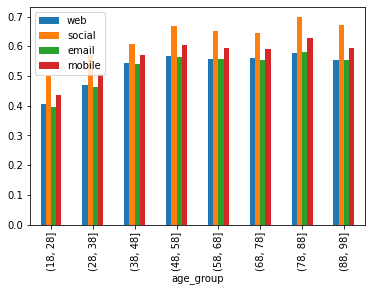

In [58]:
age_diff=np.arange(re_check_data['age'].min(), re_check_data['age'].max(), 10)
dash=pd.cut(re_check_data['age'], age_diff)
re_check_data['age_group']=dash
new_df1=pd.DataFrame(re_check_data[(re_check_data['viewed']==1) & (re_check_data['completed']==1)])
new_sent=re_check_data.groupby('age_group')[['web','social','email','mobile']].sum()
new_completed=new_df1.groupby('age_group')[['web','social','email','mobile']].sum()
new_age=new_completed/new_sent
new_age.plot.bar()

From the plot it is clear that Social channel has highest number of conversion rate

Count total number of offers sent by each channel type

In [59]:
mcomp_df1=pd.DataFrame(re_check_data[(re_check_data['viewed']==1) & (re_check_data['completed']==1)& (re_check_data['gender']=='M')][['web','social','email','mobile']].sum())
mcomp_df1

,0
web,10754
social,8926
email,12102
mobile,11360


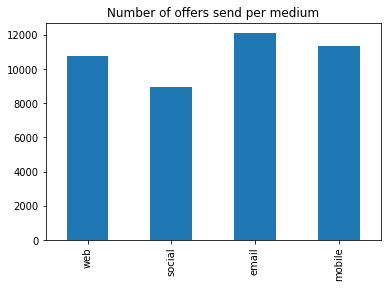

In [60]:
mcomp_df1.plot.bar(title="Number of offers send per medium", legend=None);

From the plot it is clear that email has the highest number of offers send and Social has the lowest number of offers send 

Let's check if the same pattern is followed by Gender which was followed by age

In [61]:
def prep_data(new_df, g):
    '''This function returns the plot of comparision of different offer channels
       Args:
       new_df: DataFrame containing details from profile, portfolio and transaction
       g: gender(M/F/O)
    '''

    mcomp_df1=pd.DataFrame(new_df[(new_df['viewed']==1) & (new_df['completed']==1)& (new_df['gender']==g)][['web','social','email','mobile']].sum())
    mnview_df1=pd.DataFrame(new_df[(new_df['viewed']==0) & (new_df['completed']==1)& (new_df['gender']==g)][['web','social','email','mobile']].sum())
    msent_df1=pd.DataFrame(new_df[new_df['gender']==g][['web','social','email','mobile']].sum())
    mview_df1=pd.DataFrame(new_df[(new_df['viewed']==1)& (new_df['gender']=='M')][['web','social','email','mobile']].sum())


    mvis_df=pd.concat([msent_df1, mview_df1, mcomp_df1], axis=1)
    
    
    mvis_df.columns=['Sent','Viewed','Completed']
    mvs_ratio=mvis_df['Viewed']/mvis_df['Sent']
    
    
    mcv_ratio=mvis_df['Completed']/mvis_df['Viewed']
    mcv_ratio=mvs_ratio*mcv_ratio
    
    
    f= plt.subplots(figsize=(12,10))
    plt.subplot(221)
    ax1=plt.subplot(2, 2, 1)
    mvs_ratio.plot.bar(title='Offer Viewed vs Offer Sent');
    ax2=plt.subplot(222 )
    mcv_ratio.plot.bar(title='Offer Completed vs Offer Viewed');
    plt.show()


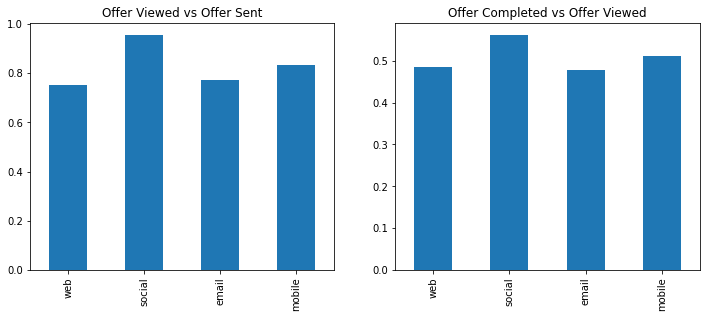

Offer Channel Comparison (Male)


In [62]:
prep_data(re_check_data,'M')
print("Offer Channel Comparison (Male)")

From the plot it is clear that Social channel has highest number of conversion rate

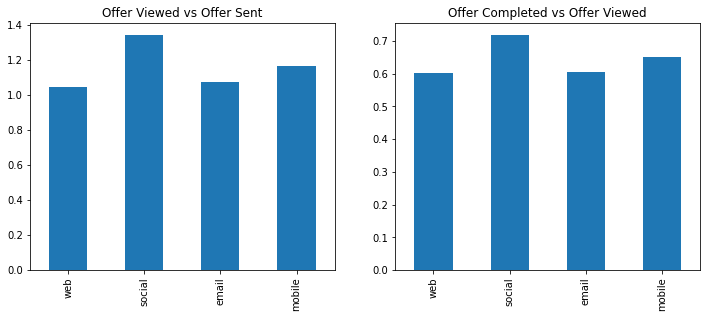

Offer Channel Comparison (Female)


In [63]:
prep_data(re_check_data,'F')
print("Offer Channel Comparison (Female)")

From the plot it is clear that Social channel has highest number of conversion rate

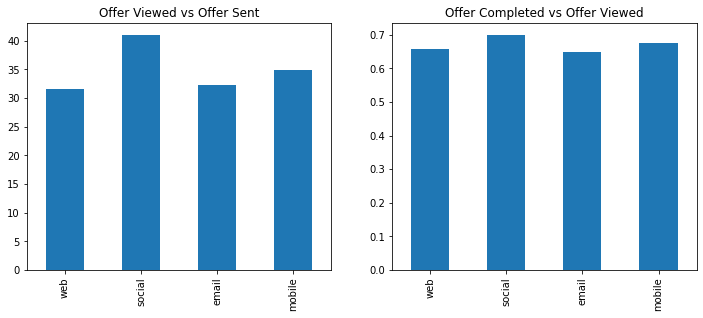

Offer Channel Comparison (Gender:'O')


In [64]:
prep_data(re_check_data,'O')
print("Offer Channel Comparison (Gender:'O')")

From the plot it is clear that Social channel has highest number of conversion rate

From all of the above plot it is clear that Social channel has highest conversion rate in every gender group and age group

Let's check if we can suggest Social as channel in any offer id

First count total offers sent with respect to offer id

In [65]:
off_sort=re_check_data.groupby('offer_id')['customer_id'].count().sort_values()
off_sort

offer_id
f19421c1d4aa40978ebb69ca19b0e20d    5445
2906b810c7d4411798c6938adc9daaa5    5480
2298d6c36e964ae4a3e7e9706d1fb8c2    5507
4d5c57ea9a6940dd891ad53e9dbe8da0    5511
9b98b8c7a33c4b65b9aebfe6a799e6d9    5542
fafdcd668e3743c1bb461111dcafc2a4    5544
ae264e3637204a6fb9bb56bc8210ddfd    5564
0b1e1539f2cc45b7b9fa7c272da2e1d7    5588
Name: customer_id, dtype: int64

Second, count the offer sent on the basis of highest conversion rate where user has viewed and completed the offer

In [66]:
on_sort=pd.DataFrame(re_check_data[(re_check_data['viewed']==1) & (re_check_data['completed']==1)]['offer_id'].value_counts())
on_sort.reset_index(level=0, inplace=True)
on_sort.rename(columns={'index':'offer_id','offer_id':'quantity'}, inplace=True)
on_sort

,offer_id,quantity
0,fafdcd668e3743c1bb461111dcafc2a4,4154
1,2298d6c36e964ae4a3e7e9706d1fb8c2,4062
2,f19421c1d4aa40978ebb69ca19b0e20d,3481
3,ae264e3637204a6fb9bb56bc8210ddfd,2813
4,4d5c57ea9a6940dd891ad53e9dbe8da0,2805
5,9b98b8c7a33c4b65b9aebfe6a799e6d9,2397
6,2906b810c7d4411798c6938adc9daaa5,2335
7,0b1e1539f2cc45b7b9fa7c272da2e1d7,1452


In [67]:
on_sort=on_sort.merge(portfolio, right_on='offer_id', left_on='offer_id')
on_sort

,offer_id,quantity,reward,channels,difficulty,duration,offer_type
0,fafdcd668e3743c1bb461111dcafc2a4,4154,2,"[web, email, mobile, social]",10,10,discount
1,2298d6c36e964ae4a3e7e9706d1fb8c2,4062,3,"[web, email, mobile, social]",7,7,discount
2,f19421c1d4aa40978ebb69ca19b0e20d,3481,5,"[web, email, mobile, social]",5,5,bogo
3,ae264e3637204a6fb9bb56bc8210ddfd,2813,10,"[email, mobile, social]",10,7,bogo
4,4d5c57ea9a6940dd891ad53e9dbe8da0,2805,10,"[web, email, mobile, social]",10,5,bogo
5,9b98b8c7a33c4b65b9aebfe6a799e6d9,2397,5,"[web, email, mobile]",5,7,bogo
6,2906b810c7d4411798c6938adc9daaa5,2335,2,"[web, email, mobile]",10,7,discount
7,0b1e1539f2cc45b7b9fa7c272da2e1d7,1452,5,"[web, email]",20,10,discount


The lowest 3 offer ids don't have Social as the channel, so if we start sending these 3 offers via Social channel there might be some increase in total conversion for these offers.

Now, let's check the spending pattern with respect to gender

In [68]:
trans_pro=profile.merge(transcript_trans, left_on='customer_id', right_on='customer_id')
trans_pro

,gender,age,customer_id,became_member_on,income,join_year,join_month,join_day,event,time,days,amount,offer_id
0,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,7,15,transaction,18,1,21.51,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,7,15,transaction,144,6,32.28,NaN
2,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,7,15,transaction,528,22,23.22,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2017,5,9,transaction,132,6,19.89,NaN
4,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2017,5,9,transaction,144,6,17.78,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
123952,F,62,e4052622e5ba45a8b96b59aba68cf068,2017-07-22,82000.0,2017,7,22,transaction,84,4,25.19,NaN
123953,F,62,e4052622e5ba45a8b96b59aba68cf068,2017-07-22,82000.0,2017,7,22,transaction,96,4,21.53,NaN
123954,F,62,e4052622e5ba45a8b96b59aba68cf068,2017-07-22,82000.0,2017,7,22,transaction,480,20,30.57,NaN
123955,F,62,e4052622e5ba45a8b96b59aba68cf068,2017-07-22,82000.0,2017,7,22,transaction,486,20,19.47,NaN


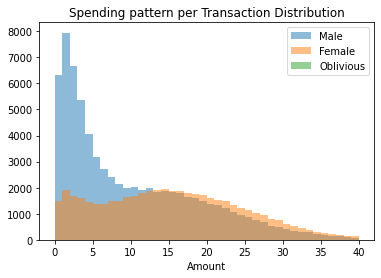

In [69]:
plt.hist(trans_pro[trans_pro['gender'] == 'M']['amount'], range=(0, 40), alpha=0.5, bins=40, label='Male')
plt.hist(trans_pro[trans_pro['gender'] == 'F']['amount'], range=(0, 40), alpha=0.5, bins=40, label='Female')
plt.hist(trans_pro[trans_pro['gender'] == '0']['amount'], range=(0, 40), alpha=0.5, bins=40, label='Oblivious')
plt.legend(loc='upper right')

plt.title('Spending pattern per Transaction Distribution')
plt.xlabel('Amount')
plt.show()

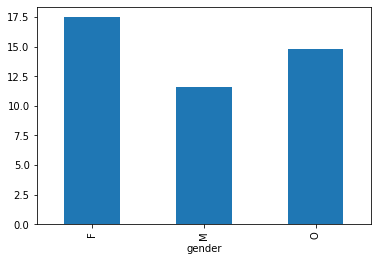

In [70]:
gen_pro=trans_pro[['gender','amount']]
gen_pro=gen_pro.groupby('gender')['amount'].mean()
gen_pro.plot.bar()

Interpretation of above plots:

For male, the buying frquency is high however, the amount of purchase is lower than female, so to increase the amount, we need to find the mean value of all the purchases made by male population and then create offers around that amount
This would be the mean value of amount that is paid by male, we need to build more packages around it. That would increase the sales volume


For female customers we need to increase the frequency as the average speding amount is more than male
We need to create offer with lower validity (duration) and lower difficulties similar to two top viewed as well as complted offers. this will increase the frequency

Now, let's look into the details of how much amount we lost due to offers which are completed without being viewed.

In [71]:
loss_df1=pd.DataFrame(re_check_data[(re_check_data['viewed']==0) & (re_check_data['completed']==1)])
loss_df1.reset_index(drop=True, inplace=True)
loss_df1

,customer_id,received,viewed,completed,offer_id,reward,difficulty,duration,offer_type_bogo,offer_type_discount,offer_type_informational,social,mobile,web,email,gender,age,income,age_group
0,0009655768c64bdeb2e877511632db8f,1,0,1,2906b810c7d4411798c6938adc9daaa5,2,10,7,0,1,0,0,1,1,1,M,33,72000.0,"(28, 38]"
1,005500a7188546ff8a767329a2f7c76a,1,0,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,5,7,1,0,0,0,1,1,1,M,56,47000.0,"(48, 58]"
2,00715b6e55c3431cb56ff7307eb19675,1,0,1,4d5c57ea9a6940dd891ad53e9dbe8da0,10,10,5,1,0,0,1,1,1,1,F,58,119000.0,"(48, 58]"
3,00840a2ca5d2408e982d56544dc14ffd,1,0,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,5,7,1,0,0,0,1,1,1,M,26,61000.0,"(18, 28]"
4,0099bf30e4cb4265875266eb3eb25eab,1,0,1,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,20,10,0,1,0,0,0,1,1,M,61,66000.0,"(58, 68]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4438,f97af6e7c31b4e16b078c3224b78f6a4,1,0,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,5,7,1,0,0,0,1,1,1,F,55,72000.0,"(48, 58]"
4439,fd66b15232a6437c86ad584849360e6f,1,0,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,5,7,1,0,0,0,1,1,1,F,52,85000.0,"(48, 58]"
4440,ffac285a64714aca8efd8d61a5606e84,1,0,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,5,7,1,0,0,0,1,1,1,M,28,36000.0,"(18, 28]"
4441,55d77afdd5fd481aafc282f23516d7c0,1,0,1,ae264e3637204a6fb9bb56bc8210ddfd,10,10,7,1,0,0,1,1,0,1,F,49,88000.0,"(48, 58]"


Total Loss

In [72]:
print ('Total Looss:',loss_df1.reward.sum())

Total Looss: 20544


To find which offer causes the most loss

In [94]:
offer_loss=loss_df1.groupby('offer_id')['reward'].sum().sort_values(ascending=False)
offer_loss

offer_id
0b1e1539f2cc45b7b9fa7c272da2e1d7    7460
9b98b8c7a33c4b65b9aebfe6a799e6d9    6150
ae264e3637204a6fb9bb56bc8210ddfd    3330
2906b810c7d4411798c6938adc9daaa5    2096
4d5c57ea9a6940dd891ad53e9dbe8da0     600
f19421c1d4aa40978ebb69ca19b0e20d     405
2298d6c36e964ae4a3e7e9706d1fb8c2     315
fafdcd668e3743c1bb461111dcafc2a4     188
Name: reward, dtype: int64

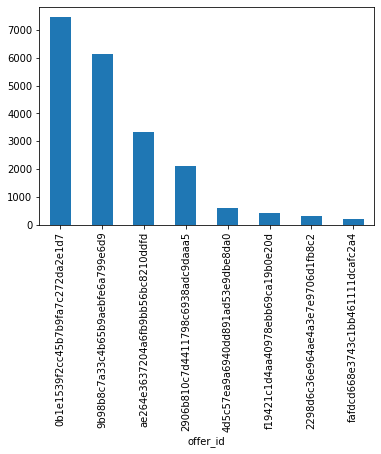

In [96]:
offer_loss.plot.bar();


In [4]:
age_diff=np.arange(re_check_data['age'].min(), re_check_data['age'].max(), 10)
dash=pd.cut(re_check_data['age'], age_diff)
re_check_data['age_group']=dash
new_df1=pd.DataFrame(re_check_data[(re_check_data['viewed']==1) & (re_check_data['completed']==1)])
new_sent=re_check_data.groupby('age_group')[['web','social','email','mobile']].sum()
new_completed=new_df1.groupby('age_group')[['web','social','email','mobile']].sum()
new_age=new_completed/new_sent
new_age.plot.bar()

NameError: name 're_check_data' is not defined

In [74]:
re_check_data

,customer_id,received,viewed,completed,offer_id,reward,difficulty,duration,offer_type_bogo,offer_type_discount,offer_type_informational,social,mobile,web,email,gender,age,income,age_group
0,0009655768c64bdeb2e877511632db8f,1,0,1,2906b810c7d4411798c6938adc9daaa5,2,10,7,0,1,0,0,1,1,1,M,33,72000.0,"(28, 38]"
1,0009655768c64bdeb2e877511632db8f,1,1,1,f19421c1d4aa40978ebb69ca19b0e20d,5,5,5,1,0,0,1,1,1,1,M,33,72000.0,"(28, 38]"
2,0009655768c64bdeb2e877511632db8f,1,1,1,fafdcd668e3743c1bb461111dcafc2a4,2,10,10,0,1,0,1,1,1,1,M,33,72000.0,"(28, 38]"
3,00426fe3ffde4c6b9cb9ad6d077a13ea,1,0,0,2906b810c7d4411798c6938adc9daaa5,2,10,7,0,1,0,0,1,1,1,F,19,65000.0,"(18, 28]"
4,00426fe3ffde4c6b9cb9ad6d077a13ea,1,1,1,fafdcd668e3743c1bb461111dcafc2a4,2,10,10,0,1,0,1,1,1,1,F,19,65000.0,"(18, 28]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44176,86114b8f1921463f8991c68520ccf5c4,1,1,1,ae264e3637204a6fb9bb56bc8210ddfd,10,10,7,1,0,0,1,1,0,1,F,66,59000.0,"(58, 68]"
44177,930305f046fa4f218d2539fb99baefb9,1,1,0,ae264e3637204a6fb9bb56bc8210ddfd,10,10,7,1,0,0,1,1,0,1,M,68,38000.0,"(58, 68]"
44178,948ec827ac334c8782a1da99a2d6a39b,1,1,1,ae264e3637204a6fb9bb56bc8210ddfd,10,10,7,1,0,0,1,1,0,1,M,61,44000.0,"(58, 68]"
44179,d957b9bd21fd4cacb39aab4b2834704b,1,1,0,ae264e3637204a6fb9bb56bc8210ddfd,10,10,7,1,0,0,1,1,0,1,F,82,84000.0,"(78, 88]"


In [75]:
temp_data=re_check_data.drop(['customer_id','received','offer_type_informational','email'], axis=1)

In [76]:
# One-Hot encoding of offer type column
df_temp=pd.get_dummies(data=temp_data[['offer_id','gender']], prefix='')
temp_data=pd.concat([temp_data, df_temp], axis=1)
temp_data.drop(['offer_id','gender'], axis=1, inplace=True)


In [77]:
temp_data.age_cat=temp_data.age_group.factorize()[0]
temp_data.drop(['age_group'], axis=1, inplace=True)
temp_data


,viewed,completed,reward,difficulty,duration,offer_type_bogo,offer_type_discount,social,mobile,web,...,_2298d6c36e964ae4a3e7e9706d1fb8c2,_2906b810c7d4411798c6938adc9daaa5,_4d5c57ea9a6940dd891ad53e9dbe8da0,_9b98b8c7a33c4b65b9aebfe6a799e6d9,_ae264e3637204a6fb9bb56bc8210ddfd,_f19421c1d4aa40978ebb69ca19b0e20d,_fafdcd668e3743c1bb461111dcafc2a4,_F,_M,_O
0,0,1,2,10,7,0,1,0,1,1,...,0,1,0,0,0,0,0,0,1,0
1,1,1,5,5,5,1,0,1,1,1,...,0,0,0,0,0,1,0,0,1,0
2,1,1,2,10,10,0,1,1,1,1,...,0,0,0,0,0,0,1,0,1,0
3,0,0,2,10,7,0,1,0,1,1,...,0,1,0,0,0,0,0,1,0,0
4,1,1,2,10,10,0,1,1,1,1,...,0,0,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44176,1,1,10,10,7,1,0,1,1,0,...,0,0,0,0,1,0,0,1,0,0
44177,1,0,10,10,7,1,0,1,1,0,...,0,0,0,0,1,0,0,0,1,0
44178,1,1,10,10,7,1,0,1,1,0,...,0,0,0,0,1,0,0,0,1,0
44179,1,0,10,10,7,1,0,1,1,0,...,0,0,0,0,1,0,0,1,0,0


In [78]:
temp_data.corr()

,viewed,completed,reward,difficulty,duration,offer_type_bogo,offer_type_discount,social,mobile,web,...,_2298d6c36e964ae4a3e7e9706d1fb8c2,_2906b810c7d4411798c6938adc9daaa5,_4d5c57ea9a6940dd891ad53e9dbe8da0,_9b98b8c7a33c4b65b9aebfe6a799e6d9,_ae264e3637204a6fb9bb56bc8210ddfd,_f19421c1d4aa40978ebb69ca19b0e20d,_fafdcd668e3743c1bb461111dcafc2a4,_F,_M,_O
viewed,1.000000,0.193793,0.125842,-0.313728,-0.245175,0.162406,-0.162406,0.541598,0.386708,-0.108218,...,0.170447,-0.201847,0.171035,-0.203077,0.108218,0.170504,0.173775,0.017170,-0.022555,0.023226
completed,0.193793,1.000000,-0.130458,-0.096435,0.038337,-0.070697,0.070697,0.053393,0.083343,0.052766,...,0.097230,-0.011791,-0.088144,0.017291,-0.052766,0.016901,0.105114,0.166345,-0.169929,0.018461
reward,0.125842,-0.130458,1.000000,0.062863,-0.457199,0.752786,-0.752786,0.323159,0.032508,-0.602121,...,-0.284567,-0.409581,0.598835,-0.032354,0.602121,-0.032030,-0.412307,0.000643,0.000154,-0.003373
difficulty,-0.313728,-0.096435,0.062863,1.000000,0.642819,-0.478987,0.478987,-0.356764,-0.883902,-0.030027,...,-0.224160,0.029767,0.029863,-0.394928,0.030027,-0.390966,0.029965,0.002588,-0.001813,-0.003247
duration,-0.245175,0.038337,-0.457199,0.642819,1.000000,-0.700492,0.700492,-0.325540,-0.583582,0.055224,...,-0.054900,-0.054746,-0.477518,-0.055099,-0.055224,-0.474246,0.580949,0.000166,-0.000459,0.001251
offer_type_bogo,0.162406,-0.070697,0.752786,-0.478987,-0.700492,1.000000,-1.000000,0.257225,0.380026,-0.380071,...,-0.376867,-0.375810,0.377997,0.379211,0.380071,0.375407,-0.378312,0.000482,-0.000516,0.000152
offer_type_discount,-0.162406,0.070697,-0.752786,0.478987,0.700492,-1.000000,1.000000,-0.257225,-0.380026,0.380071,...,0.376867,0.375810,-0.377997,-0.379211,-0.380071,-0.375407,0.378312,-0.000482,0.000516,-0.000152
social,0.541598,0.053393,0.323159,-0.356764,-0.325540,0.257225,-0.257225,1.000000,0.490247,-0.294620,...,0.292891,-0.484809,0.293013,-0.487935,0.294620,0.291005,0.294014,-0.004369,0.005121,-0.003283
mobile,0.386708,0.083343,0.032508,-0.883902,-0.583582,0.380026,-0.380026,0.490247,1.000000,-0.144437,...,0.143589,0.143187,0.143649,0.144110,0.144437,0.142664,0.144140,-0.003899,0.003930,-0.000207
web,-0.108218,0.052766,-0.602121,-0.030027,0.055224,-0.380071,0.380071,-0.294620,-0.144437,1.000000,...,0.143236,0.142835,0.143295,0.143756,-1.000000,0.142313,0.143785,0.000683,-0.000447,-0.000987


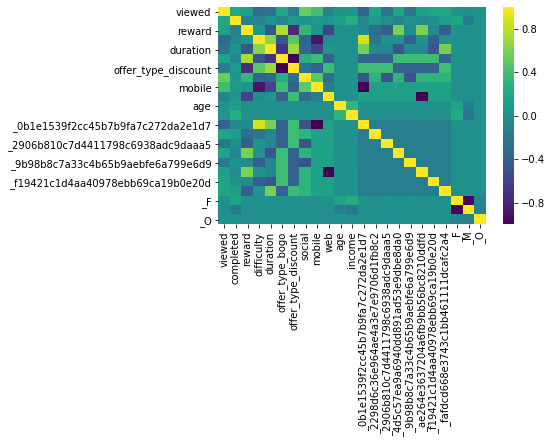

In [79]:
sns.heatmap(temp_data.corr(),cmap='viridis')

So, now we will try to find out if the send an offer, are they going to view it and then complete it
This way we can test who we should send the offer and who we should not send the offer

In [80]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.constraints import max_norm
from sklearn.preprocessing import MinMaxScaler

In [81]:
temp_data['Sucess']=temp_data['viewed']*temp_data['completed']

In [82]:
X=temp_data.drop(['viewed','completed','Sucess'], axis=1)
y=temp_data['Sucess']

In [83]:
from xgboost import XGBClassifier
prom_model=XGBClassifier(learning_rate = 0.1,\
                                  num_class=4,\
                                      max_depth = 7,\
                                      min_child_weight = 5,\
                                      objective = 'multi:softmax',\
                                      seed = 42,\
                                      gamma = 0.1,\
                                      silent = True)

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [85]:
y_cat_train=to_categorical(y_train,2)
y_cat_test=to_categorical(y_test,2)

In [86]:
 prom_model.fit(X_train, y_train)
    

[09:21:54] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_class=4, num_parallel_tree=1,
              objective='multi:softmax', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, seed=42, silent=True,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [87]:
%time prom_model.fit(X_train,y_train)

[09:22:03] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Wall time: 5.53 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_class=4, num_parallel_tree=1,
              objective='multi:softmax', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, seed=42, silent=True,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [88]:
y_pred=prom_model.predict(X_test)

In [89]:
accuracy=(y_pred==y_test).mean()
accuracy

0.6797555731583117

In [90]:

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [91]:
X_train.shape

(35344, 21)

In [92]:
model = Sequential()


# input layer
model.add(Dense(21,  activation='relu'))
model.add(Dropout(0.2))

# hidden layer
model.add(Dense(12, activation='relu'))
model.add(Dropout(0.2))

# hidden layer
model.add(Dense(5, activation='relu'))
model.add(Dropout(0.2))

# output layer
model.add(Dense(units=2,activation='softmax'))

# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

NameError: name 'Dense' is not defined

In [ ]:
model.fit(X_train,y_cat_train,epochs=25,batch_size=256,validation_data=(X_test,y_cat_test))

# Findings

## 1. The offers which are not on social media are least popular among the population